<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/Devito_FD_2D_wave_equation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.devitoproject.org/devito/index.html

In [1]:
# install devito
!pip install devito &> /dev/null

In [2]:
# import libraries and tools
import numpy as np

from time import perf_counter

import matplotlib
import matplotlib.pyplot as plt
# from matplotlib.gridspec import GridSpec

from devito import Grid, TimeFunction, Operator, Constant, Eq, solve, first_derivative, left

from examples.seismic import Model, plot_velocity
from examples.seismic import TimeAxis
from examples.seismic import RickerSource
from examples.seismic import Receiver

In [55]:
# define number of time steps to compute before storing result for plotting
numSnapshots = 5
batchSize = int(nt/(numSnapshots-1))

In [64]:
extent_x = 20.e3 ### METRES ###
extent_z = 10.e3 ### METRES ###

nx = 401 ### NODES ###
nz = 201 ### NODES ###

absorbingLayer = 10 ### NODES ###

nxTrue = nx + 2*absorbingLayer ### NODES ###
nzTrue = nz + 2*absorbingLayer ### NODES ###

dx = extent_x / (nx-1) ### METRES ###
dz = extent_z / (nz-1) ### METRES ###

shape = (nx, nz)
spacing = (dx, dz)
origin = (0., 0.)

v = np.empty(shape, dtype=np.float32)
v[:, :] = 2.5 ### KM/S ###
# v[:, int(shape[1]/2):] = 1.5  ### KM/S ###

model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=absorbingLayer, bcs="damp")

t0 = 0.  ### MILLISECONDS ###
# dt = 1e-1 ### MILLISECONDS ###
dt = float(int(model.critical_dt))
T = 10.e3 ### MILLISECONDS ###
nt = T / dt
time_range = TimeAxis(start=t0, stop=T, step=dt)

Operator `initdamp` ran in 0.01 s
INFO:Devito:Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
INFO:Devito:Operator `pad_vp` ran in 0.01 s


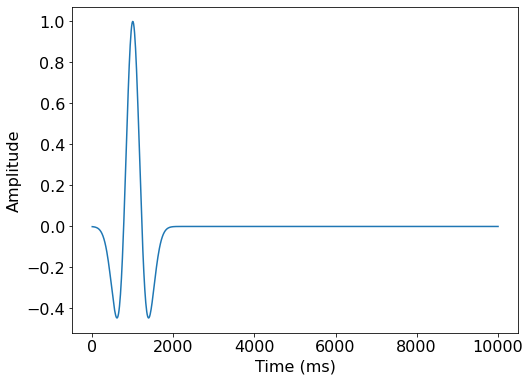

In [65]:
f0 = 0.001 ### kHZ ### # Source peak frequency is 10Hz (0.010 kHz)
src = RickerSource(name='src', grid=model.grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = extent_x*0.5 ### METRES ###
src.coordinates.data[0, 1] = 20.#extent_z*0.5 ### METRES ###
src.coordinates.data

# rec = Receiver(name='rec', grid=model.grid, npoint=101, time_range=time_range)
# rec.coordinates.data[:, 0] = np.linspace(0, model.domain_size[0], num=101) ### METRES ###
# rec.coordinates.data[:, 1] = 20.  ### METRES ###

u = TimeFunction(name="u", grid=model.grid, time_order=2, space_order=2)
pde = model.m * u.dt2 - u.laplace + model.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))

src_term = src.inject(field=u.forward, expr=src * dt**2 / model.m)
# rec_term = rec.interpolate(expr=u.forward)

op = Operator([stencil] + src_term, subs=model.spacing_map) # + rec_term
src.show()

In [62]:
# print(batchSize)

# initialise empty array to store computed solution
results = np.zeros((numSnapshots, nxTrue, nzTrue))
# store initial conditions in results array
results[0,:,:] = u.data[0].copy()

# log start time to measure performance
startTime = perf_counter()

# iterate over result steps
# start from 1 not 0 as results at step 0 are the initial conditions
elapsedTime = 0
for resultStep in range(1, numSnapshots):
    # compute solution after batchSize time steps
    if elapsedTime > 3000:
        src_term = src.inject(field=u.forward, expr=src * 0.)
    summary = op.apply(time=batchSize, dt=dt)
    # store computed solution in results array
    results[resultStep,:,:] = u.data[0].copy()

    elapsedTime += batchSize*dt

print(elapsedTime)

# log end time to measure performance
endTime = perf_counter()
# print total training time
print(f'Training duration: {(endTime-startTime):.2f}s')

x = np.arange(0, nxTrue*dx, dx)
y = np.arange(0, nzTrue*dz, dz)
# create meshgrid arrays
mesh_x, mesh_y = np.meshgrid(x, y)
print(mesh_x.shape)
print(mesh_y.shape)
print(results.shape)

# print(time)

Operator `Kernel` ran in 0.04 s
INFO:Devito:Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
INFO:Devito:Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.04 s
INFO:Devito:Operator `Kernel` ran in 0.04 s
Operator `Kernel` ran in 0.03 s
INFO:Devito:Operator `Kernel` ran in 0.03 s


9984.0
Training duration: 0.54s
(221, 421)
(221, 421)
(5, 421, 221)


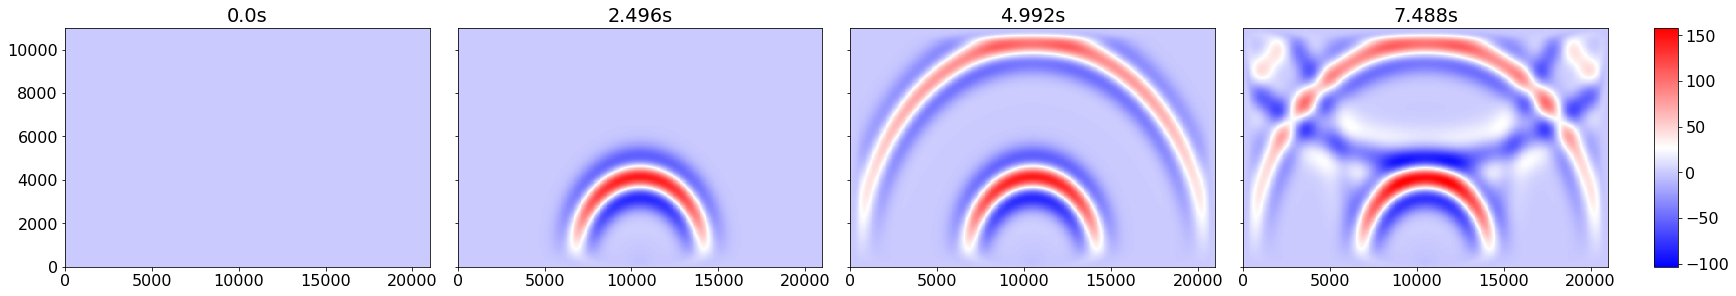

In [63]:
numPlots = 4

fig, axs = plt.subplots(1, numPlots,
                        figsize=(24, 4),
                        constrained_layout=True,
                        sharey=True,
                        )

norm = matplotlib.colors.Normalize(results[:,:].min(),results[:,:].max())
cmap = matplotlib.cm.get_cmap('bwr')
mapping = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

for idx, ax in enumerate(axs):
    # if idx < 5:
    plot = ax.pcolormesh(mesh_x, mesh_y, results[idx*int(results.shape[0]/numPlots), :, :].T, norm=norm, cmap='bwr')
    ax.invert_yaxis()
    ax.set_title(f'{(batchSize*dt*idx*int(results.shape[0]/numPlots))/1000}s')
    # else:
    #     plot = ax.pcolormesh(mesh_x, mesh_y, results[-1, :, :].T, norm=norm, cmap='bwr')
    #     ax.invert_yaxis()
    #     ax.set_title(f'{(T)/1000}s')
fig.colorbar(mapping, ax=axs.ravel(), aspect=60)

plt.show()

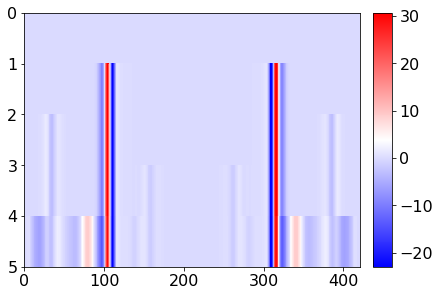

In [ ]:
fig, ax = plt.subplots(#1, 5,
                        figsize=(6, 4),
                        constrained_layout=True,
                        # sharey=True,
                        )

# norm = matplotlib.colors.Normalize(results[:,:].min(),results[:,:].max())
# cmap = matplotlib.cm.get_cmap('bwr')
# mapping = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)

# for idx, ax in enumerate(axs):
plot = ax.pcolormesh(results[:,:,25], cmap='bwr' )#norm=norm, cmap='bwr') # mesh_x, mesh_y,


ax.invert_yaxis()
fig.colorbar(plot)#, ax=axs.ravel(), aspect=60)

plt.show()

## End

In [ ]:
# define viscosity
nu = 0.01/np.pi

In [ ]:
# define discretisation

# extent x direction
X = 2.0
# number of x grid points
nx = 1001
# x direction step size
dx = X / (nx - 1)

# time extent (total duration)
T = 1 
# time step
dt = 1e-4
# number of time points
nt = int((T / dt) + 1)

In [ ]:
# create 1D grid and assign dimension variable names
grid = Grid(shape=(nx), extent=(X))

x = grid.dimensions
t = grid.stepping_dim

In [ ]:
# create time function on grid
# space order of 2 to enable 2nd derivative
u = TimeFunction(name='u', grid=grid, space_order=2)

In [ ]:
# create constant (viscosity)
a = Constant(name='a')
# define 1D Burgers' equation
equation_u = Eq(u.dt + u*u.dxl, a*u.dx2)
equation_u

Eq(u(t, x)*Derivative(u(t, x), x) + Derivative(u(t, x), t), a*Derivative(u(t, x), (x, 2)))

In [ ]:
# create stencil by solving for next time step
stencil_u = solve(equation_u, u.forward)
stencil_u

dt*(a*Derivative(u(t, x), (x, 2)) - u(t, x)*Derivative(u(t, x), x) + u(t, x)/dt)

In [ ]:
# define equation for next time step
update_u = Eq(u.forward, stencil_u)
update_u

Eq(u(t + dt, x), dt*(a*Derivative(u(t, x), (x, 2)) - u(t, x)*Derivative(u(t, x), x) + u(t, x)/dt))

In [ ]:
# define boundary conditions
# u = 0 at min and max extent of x
boundaryConditions = [Eq(u[t+1, 0], 0.)]
boundaryConditions += [Eq(u[t+1, nx], 0.)]

In [ ]:
# define operator based on equation and boundary conditions
op = Operator([update_u] + boundaryConditions)

In [ ]:
# set solution space to 0s
u.data[:] = 0

# create a dummy x array from -1 to +1
dummyX = np.arange(-1, 1+dx, dx)

# set initial conditions using dummy x array
u.data[0] = -1 * np.sin(np.pi * dummyX)

In [ ]:
# define number of time steps to compute before storing result for plotting
batchSize = 100

# initialise empty array to store computed solution
results = np.zeros((nx, int(nt / batchSize)))
# store initial conditions in results array
results[:,0] = u.data[0].copy()

# log start time to measure performance
startTime = perf_counter()

# iterate over result steps
# start from 1 not 0 as results at step 0 are the initial conditions
for timeStep in range(1, int(nt / batchSize)):
    # compute solution after batchSize time steps
    summary = op.apply(time=batchSize, dt=dt, a=nu)
    # store computed solution in results array
    results[:,timeStep] = u.data[0].copy()

# log end time to measure performance
endTime = perf_counter()
# print total training time
print(f'Training duration: {(endTime-startTime):.2f}s')

Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator `Kernel` ran in 0.01 s
Operator

Training duration: 0.96s


In [ ]:
# define arrays for creating meshgrid for plotting solution results
xPlot = np.arange(0, T, dt*batchSize)
yPlot = np.arange(-1, 1+dx, dx)
# create meshgrid from arrays
X, Y = np.meshgrid(xPlot, yPlot)

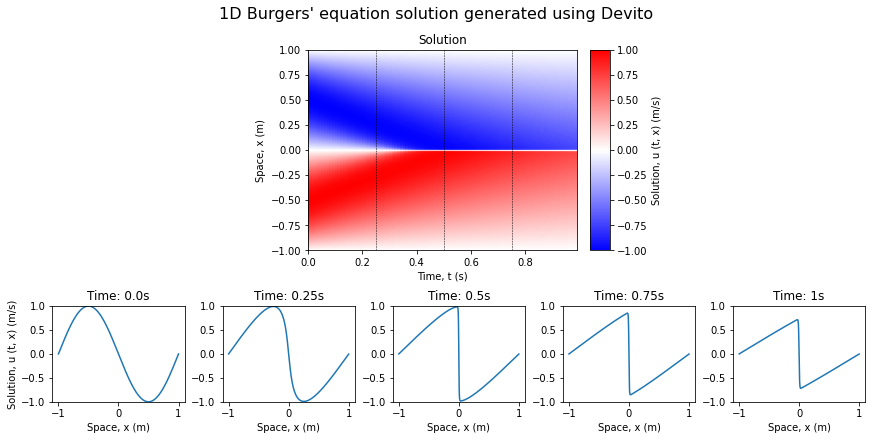

In [ ]:
# create figure using gridspec to structure subplots
fig = plt.figure(
    figsize=(12, 6),
    constrained_layout=True
    )
gs = GridSpec(3, 20, figure=fig)

# add main solution plot
solutionAx = fig.add_subplot(gs[:2,5:15])
solutionPlot = solutionAx.pcolormesh(X, Y, results, cmap='bwr')
solutionAx.set_title('Solution')
solutionAx.set_xlabel('Time, t (s)')
solutionAx.set_ylabel('Space, x (m)')
cbar = fig.colorbar(solutionPlot, use_gridspec=True)
cbar.set_label('Solution, u (t, x) (m/s)')

# iteratively create solution snapshot subplots
for i in range(5):
    tPlot = fig.add_subplot(gs[2, i*4:(i+1)*4])    
    if i < 4:
        tPlot.plot(Y[:, i*(Y.shape[1]//4)], results[:, i*(Y.shape[1]//4)])
        tPlot.set_title('Time: ' + str(i*X[0, X[0].shape[0]//4]) + 's')
        # add vertical lines to solution plot to indicate snapshots
        solutionAx.vlines(x=i*X[0, X[0].shape[0]//4], ymin=Y[0,0], ymax=Y[-1,0], colors='black', ls='--', lw=0.5)
    else:
        tPlot.plot(Y[:, -1], results[:, -1])
        tPlot.set_title('Time: ' + str(T) + 's')
    
    tPlot.set_ylim([-1, 1])
    tPlot.set_xlabel('Space, x (m)')
    if i == 0:
        tPlot.set_ylabel('Solution, u (t, x) (m/s)')

# figure title
fig.suptitle("1D Burgers' equation solution generated using Devito", fontsize=16)

# fig.savefig("1D Burgers' - devito", bbox_inches='tight')
plt.show()